In [1]:
import spot
from buddy import bddtrue
spot.setup()

# Support for games

The support for games is currently quite rudimentary, as Spot currently only uses those games in `ltlsynt`.

In essence, a game is just an ω-automaton with a property named `state-player` that stores the player owning each state.  The players are named 0 and 1.  The player owning a state can decide what the next transition from this state should be.  The goal for player 1 is to force the play to be infinite and to satisfy the acceptance condition of the automaton, while the goal for player 0 is to prevent it by either forcing a finite play, or forcing an infinite play that does not satisfy the acceptance condition.

The support is currently restricted to games that use:
- `t` acceptance: all infinite run are accepting, and player 0 can only win if it manages to force a finite play (this requires reaching states without successors).
- `parity` acceptance of any form (`max odd`, `max even`, `min odd`, `min even`): player 0 can win if the maximal (or minimal) value seen infinitely often is even (or odd)

# Creating games from scratch

Games can be [created like any automaton](https://spot.lrde.epita.fr/tut22.html).  
Using `set_state_players()` will fix the state owners.

In [2]:
bdict = spot.make_bdd_dict();
game = spot.make_twa_graph(bdict)
game.new_states(9)
for (s, d) in ((0,1), (0, 3), 
               (1, 0), (1, 2),
               (2, 1), (2, 5),
               (3, 2), (3, 4), (3, 6),
               (6, 7),
               (7, 6), (7, 8),
               (8, 5)):
    game.new_edge(s, d, bddtrue)
spot.set_state_players(game, [True, False, True, False, True, True, True, False, False])
game.show('.g')  # Use "g" to hide the irrelevant edge labels.

The `set_state_players()` function takes a list of owner for each of the states in the automaton.  In the output,
states from player 0 use circles, ellipses, or rectangle with rounded corners (mnemonic: 0 is round) while states from player 1 have a losanse shape (1 has only straight lines). 


State ownership can also be manipulated by the following functions:

In [3]:
spot.get_state_players(game)

(True, False, True, False, True, True, True, False, False)

In [4]:
spot.get_state_player(game, 4)

True

In [5]:
spot.set_state_player(game, 4, False)
game.show('.g')

# Solving a game

Solving a game is done my calling `solve_game()`.   This function actually dispatches to `solve_safety_game()` (if the acceptance is `t`) or to `solve_parity_game()` (if the acceptance is any parity condition).  You may call these functions directly if desired, but using `solve_game()` makes it possible for future version of Spot to dispatch to some better function if we add some.

These functions will attach two additional vectors into the game automaton: one vector stores the winner of each state, and one vector stores (memory-less) strategy for each state, i.e., the transition that should always be taken by the owner of this state in order to win.  

The return value of those functions is simply the winner for the initial state.

In [6]:
spot.solve_game(game)

True

Calling the `highlight_strategy()` function can be used to decorate the `game` automaton using the winning regions and strategies.  Below, green represent the winning region/strategy for player 1 and red those for player 0.

In [7]:
spot.highlight_strategy(game)
game.show('.g')

## Input/Output in HOA format

An extension of the HOA format makes it possible to store the `state-player` property.  This allows us to read the parity game constructed by `ltlsynt` using `spot.automaton()` like any other automaton.

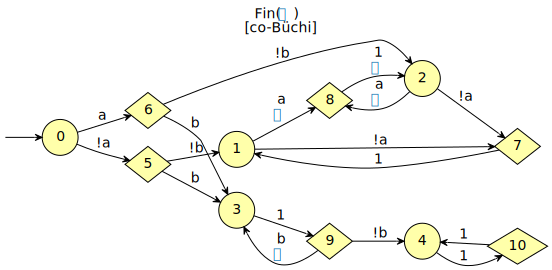

In [8]:
game = spot.automaton("ltlsynt --ins=a --outs=b -f '!b & GFa <-> Gb' --print-game-hoa |");
game

In the graphical output, player 0 is represented by circles (or ellipses or rounded rectangles depending on the situations), while player 1's states are diamond shaped.  In the case of `ltlsynt`, player 0 plays the role of the environment, and player 1 plays the role of the controller.

In the HOA output, a header `spot-state-player` (or `spot.state-player` in HOA 1.1) lists the owner of each state.

In [9]:
print(game.to_str('hoa'))

HOA: v1
States: 11
Start: 0
AP: 2 "b" "a"
acc-name: co-Buchi
Acceptance: 1 Fin(0)
properties: trans-labels explicit-labels trans-acc complete
properties: deterministic
spot-state-player: 0 0 0 0 0 1 1 1 1 1 1
controllable-AP: 0
--BODY--
State: 0
[!1] 5
[1] 6
State: 1
[!1] 7
[1] 8 {0}
State: 2
[!1] 7
[1] 8 {0}
State: 3
[t] 9
State: 4
[t] 10
State: 5
[!0] 1
[0] 3
State: 6
[!0] 2
[0] 3
State: 7
[t] 1
State: 8
[t] 2 {0}
State: 9
[0] 3 {0}
[!0] 4
State: 10
[t] 4
--END--


Here is the solution of this particular game.

In [10]:
spot.solve_parity_game(game)

True

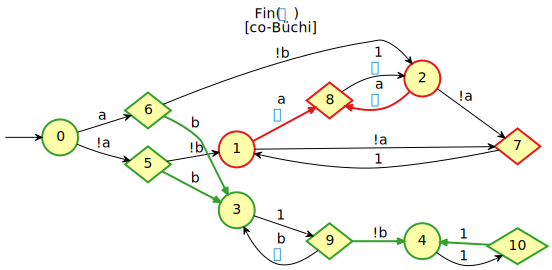

In [11]:
spot.highlight_strategy(game)

# Input/Output in PGSolver format

The automaton parser is also able to parse the [PGSolver](https://github.com/tcsprojects/pgsolver) format.  Here are two examples from the manual of PGSolver.  The support for C-style comments is not part of the PGSolver format.

Note that we use diamond node for player 1, while PGSolver use those of player 0.  Also in Spot the acceptance condition is what Player 1 should satisfy; player 0 has two way to not satisfy it: leading to a rejecting cycle, or to a state without successor.  In PGSolver, the graph is assumed to be total (i.e. each state has a successor), so player 0 can only win by reaching a rejecting cycle, which is equivalent to a `parity max even` acceptance.

In [12]:
a,b = spot.automata("""
parity 4;  /* Example 6 in the manual for PGSolver 4.1 */
0 6 1 4,2 "Africa";
4 5 1 0 "Antarctica";
1 8 1 2,4,3 "America";
3 6 0 4,2 "Australia";
2 7 0 3,1,0,4 "Asia";
parity 8;  /* Example 7 in the manual for PGSolver 4.1 */
0 0 0 1,2;
1 1 1 2,3;
2 0 0 3,4;
3 1 1 4,5;
4 0 0 5,6;
5 1 1 6,7;
6 0 0 7,0;
7 1 1 0,1;
""")
spot.solve_game(a)
spot.highlight_strategy(a)
spot.solve_game(b)
spot.highlight_strategy(b)
display(a.show('.g'), b.show('.g'))

To output a parity-game in PG-solver format, use `to_str('pg')`.

In [13]:
print(a.to_str('pg') + b.to_str('pg'))

parity 4;
0 6 1 4,2 "Africa";
2 7 0 3,1,0,4 "Asia";
4 5 1 0 "Antarctica";
1 8 1 2,4,3 "America";
3 6 0 4,2 "Australia";
parity 7;
0 0 0 1,2;
2 0 0 3,4;
4 0 0 5,6;
6 0 0 7,0;
7 1 1 0,1;
1 1 1 2,3;
3 1 1 4,5;
5 1 1 6,7;



# Global vs local solver

The parity game solver now supports "local" and global solutions.

- "Local" solutions are the ones computed so far. A strategy is only computed for the part of the automaton that is reachable from the initial state
- Global solutions can now be obtained by setting the argument "solve_globally" to true. In this case a strategy will be computed even for states not reachable in the original automaton.


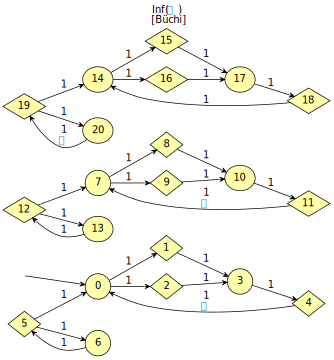

In [14]:
arena = spot.make_twa_graph()

arena.new_states(3*7)
arena.set_buchi()

edges = [(0,1), (0,2), (1,3), (2,3), (3,4), (4,0), (5,0), (5,6), (6,5)]

for src, dst in edges:
    arena.new_edge(src, dst, bddtrue, [0] if src == 4 else [])
    arena.new_edge(src + 7, dst + 7, bddtrue, [0] if src == 4 else [])
    arena.new_edge(src + 14, dst + 14, bddtrue, [0] if src == 6 else [])

arena.set_state_players(3*[False, True, True, False, True, True, False])
arena

(0, 7, 10, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


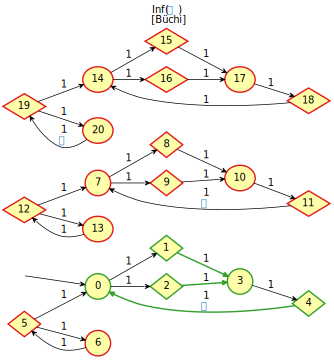

In [15]:
# 1) Solving the game locally
# Unreachable parts are ignored, all of them are "won" by the env,
# the associated strategy is the 0 edges indicating no strategy
spot.solve_parity_game(arena)
spot.highlight_strategy(arena)
print(arena.get_strategy())
arena

(0, 7, 10, 0, 16, 19, 0, 0, 8, 11, 0, 17, 20, 0, 3, 0, 0, 15, 0, 24, 0)


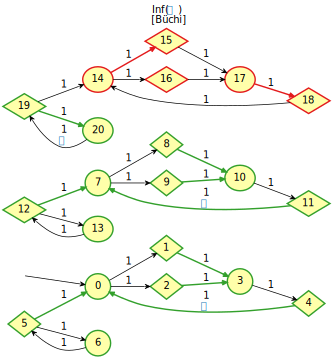

In [16]:
# 1) Solving the game globally
# The whole automaton is considered in this case
spot.solve_parity_game(arena, True)
spot.highlight_strategy(arena)
print(arena.get_strategy())
arena